# Installing packages and import libraries

In [1]:
!pip install imbalanced-learn
!pip install scikeras

In [3]:
# Data manipulation and visualization libraries
import pandas as pd
import numpy as np
import seaborn as sb
from geopy.distance import geodesic
import matplotlib.pyplot as plt

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

# Deep learning
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM, Dropout, Dense
from keras.optimizers import  SGD, Adam
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from scikeras.wrappers import KerasClassifier

# Data Preprocessing

## Import data

In [4]:
# Import from my drive and display the first 5 rows
# NB! Remember to edit the path when running the notebook elsewhere
path = "/content/drive/MyDrive/USN (Skole)/Industrimaster/Data Science (CS4020)/Project/Colab/"
df_overflow = pd.read_csv(f'{path}overflow_export.csv')
df_weather = pd.read_csv(f'{path}weather_station_export.csv')

In [5]:
print(df_overflow.head())
print(df_weather.head())

                bucket  overflow  warning              name  latitude  \
0  2020-10-26 11:00:00         1        1  21-1036-AA-00003  59.40472   
1  2020-10-26 12:00:00         1        1  21-1036-AA-00003  59.40472   
2  2020-10-26 12:00:00         0        0  21-1036-AA-00001  59.39825   
3  2020-10-26 12:00:00         0        1  21-1036-AA-00004  59.40752   
4  2020-10-26 13:00:00         0        1  21-1036-AA-00001  59.39825   

   longitude  
0   10.48086  
1   10.48086  
2   10.47472  
3   10.48266  
4   10.47472  
                bucket  rain_hour  temperature  pressure_relative  wind_speed  \
0  2020-11-11 16:00:00      0.000         7.15               1023       5.930   
1  2020-11-11 16:00:00      0.155         6.96               1016       0.714   
2  2020-11-11 16:00:00      0.977         6.94               1023       5.750   
3  2020-11-11 16:00:00      0.223         7.03               1015       0.000   
4  2020-11-11 16:00:00      0.445         7.31               1023 

## Check for and handle null values

In [6]:
# Check for null values
print(df_overflow.isnull().sum())
print('#-----------------------#')
print(df_weather.isnull().sum())

bucket          0
overflow        0
warning         0
name            0
latitude     2310
longitude    2310
dtype: int64
#-----------------------#
bucket                   0
rain_hour                0
temperature              0
pressure_relative        0
wind_speed               0
name                     0
latitude             28435
longitude            28435
dtype: int64


In [7]:
# Since the geo-location is missing, drop those columns
df_overflow.dropna(subset=['latitude','longitude'], inplace=True)
df_weather.dropna(subset=['latitude','longitude'], inplace=True)

## Time conversion

In [8]:
# Convert bucket column from epoch ms to datetime
df_weather['time'] = pd.to_datetime(df_weather['bucket'], unit='ns')
df_overflow['time'] = pd.to_datetime(df_overflow['bucket'], unit='ns')

# Convert from UTC to local time
df_overflow['time'] = df_overflow['time'].dt.tz_localize('utc').dt.tz_convert('Europe/Oslo')
df_weather['time'] = df_weather['time'].dt.tz_localize('utc').dt.tz_convert('Europe/Oslo')

In [9]:
# Drop the bucket columns
df_weather = df_weather.drop(axis='columns', columns='bucket')
df_overflow = df_overflow.drop(axis='columns', columns='bucket')

In [10]:
print(df_overflow.head())
print(df_weather.head())

   overflow  warning              name  latitude  longitude  \
0         1        1  21-1036-AA-00003  59.40472   10.48086   
1         1        1  21-1036-AA-00003  59.40472   10.48086   
2         0        0  21-1036-AA-00001  59.39825   10.47472   
3         0        1  21-1036-AA-00004  59.40752   10.48266   
4         0        1  21-1036-AA-00001  59.39825   10.47472   

                       time  
0 2020-10-26 12:00:00+01:00  
1 2020-10-26 13:00:00+01:00  
2 2020-10-26 13:00:00+01:00  
3 2020-10-26 13:00:00+01:00  
4 2020-10-26 14:00:00+01:00  
   rain_hour  temperature  pressure_relative  wind_speed  \
1      0.155         6.96               1016       0.714   
2      0.977         6.94               1023       5.750   
3      0.223         7.03               1015       0.000   
4      0.445         7.31               1023       1.500   
6      0.169         6.78               1016       0.442   

                      name   latitude  longitude                      time  
1  

## Merge dataframes on time

In [11]:
# Merge dataframes on time
df_merged = pd.merge(df_overflow,df_weather, how='inner', on='time')
df_merged = df_merged.rename(columns={"name_x": "sensor_name", "name_y": "weather_station_name", "latitude_x":"sensor_latitude","longitude_x":"sensor_longitude","latitude_y":"weather_station_latitude","longitude_y":"weather_station_longitude"})

## Match sensor to closest weather station

In [12]:
# Function to calculate distance between two coordinate points in km
def calcDistance(locationA, locationB):
  return geodesic(locationA, locationB).kilometers

In [13]:
# Selecting unique sensor names along with their locations
unique_sensors = df_merged[['sensor_name', 'sensor_latitude', 'sensor_longitude']].drop_duplicates()

# Selecting unique weather station names along with their locations
unique_weather_stations = df_merged[['weather_station_name', 'weather_station_latitude', 'weather_station_longitude']].drop_duplicates()

# Delete the rows where the weather station "NetatmoNykirkeKlokkeråsen"
# Delete due to bad data quality, (sensor has stored data while being indoors, under roof, burried in snow etc)
unique_weather_stations = unique_weather_stations.drop(unique_weather_stations[unique_weather_stations['weather_station_name'] == 'NetatmoNykirkeKlokkeråsen'].index)

In [14]:
# Find the closest weather station for each sensor

# Mappings of sensor to closest weather station
sensor_to_station = {} # sensor_name to weather_station_name
sensor_distances = {} # distance to closest weather station

# Loop through the rows using iterrows()
for index_x, row_x in unique_sensors.iterrows():
  min_distance = 1000
  min_distance_station = ""

  for index_y, row_y in unique_weather_stations.iterrows():
    # Calculate the distance
    distance = calcDistance((row_x['sensor_latitude'], row_x['sensor_longitude']), (row_y['weather_station_latitude'],row_y['weather_station_longitude']))

    # If distance is less than min, update distance
    if distance < min_distance:
      min_distance = distance
      min_distance_station = unique_weather_stations.loc[index_y].at['weather_station_name']

  # Add sensor to weather station mapping
  sensor_to_station[row_x["sensor_name"]] = min_distance_station
  sensor_distances[row_x["sensor_name"]] = min_distance

print(sensor_to_station)

{'21-1036-AA-00001': 'Røråsen værstasjon', '21-1036-AA-00003': 'Røråsen værstasjon', '21-1036-AA-00004': 'Røråsen værstasjon', '21-1036-AA-00011': 'Åsgårdstrand værstasjon', '21-1036-AA-00006': 'Røråsen værstasjon', '21-1036-AA-00002': 'Røråsen værstasjon', '21-1036-AA-00005': 'Røråsen værstasjon', '21-1036-AA-00008': 'Åsgårdstrand værstasjon', '21-1036-AA-00007': 'Åsgårdstrand værstasjon', '21-1036-AA-00009': 'Åsgårdstrand værstasjon', '21-1036-AA-00010': 'Røråsen værstasjon', '21-1036-AA-00020': 'Åsgårdstrand værstasjon', '21-1036-AA-00013': 'Røråsen værstasjon', '21-1036-AA-00018': 'Åsgårdstrand værstasjon', '21-1036-AA-00019': 'Åsgårdstrand værstasjon', '21-1036-AA-00021': 'Skoppum værstasjon', '21-1036-AA-00025': 'Åsgårdstrand værstasjon', '21-1036-AA-00044': 'Åsgårdstrand værstasjon', '21-1036-AA-00048': 'Skoppum værstasjon', '21-1036-AA-00017': 'Røråsen værstasjon', '21-1036-AA-00037': 'Røråsen værstasjon', '21-1036-AA-00041': 'Åsgårdstrand værstasjon', '21-1036-AA-00039': 'Åsgå

In [15]:
# Delete the rows where the weather station "NetatmoNykirkeKlokkeråsen"
# Delete due to bad data quality
df_merged = df_merged.drop(df_merged[df_merged['weather_station_name'] == 'NetatmoNykirkeKlokkeråsen'].index)

In [16]:
# Filter DataFrame based on given sensor to station mapping
filtered_df = df_merged[df_merged['weather_station_name'] == df_merged['sensor_name'].map(sensor_to_station)]

# Add a distance to weather station column
filtered_df = filtered_df.copy()
filtered_df['distance_to_weather_station'] = filtered_df['sensor_name'].map(sensor_distances)

# Remove weather station location columns
df = filtered_df.drop(columns=['weather_station_latitude','weather_station_longitude'],axis='columns')
df.tail()

,overflow,warning,sensor_name,sensor_latitude,sensor_longitude,time,rain_hour,temperature,pressure_relative,wind_speed,weather_station_name,distance_to_weather_station
2521674,0,0,21-1036-AA-00018,59.347802,10.463311,2024-03-07 19:00:00+01:00,0.0,3.99,1030,0.628,Åsgårdstrand værstasjon,0.967956
2521678,0,0,21-1036-AA-00039,59.349228,10.463828,2024-03-07 19:00:00+01:00,0.0,3.99,1030,0.628,Åsgårdstrand værstasjon,0.821889
2521680,0,0,21-1036-AA-00038,59.415879,10.489859,2024-03-07 19:00:00+01:00,0.0,3.93,1030,0.867,Røråsen værstasjon,1.500316
2521684,0,0,21-1036-AA-00042,59.432912,10.450303,2024-03-07 20:00:00+01:00,0.0,3.30,1030,1.600,Røråsen værstasjon,1.664709
2521690,0,0,21-1036-AA-00025,59.349994,10.450111,2024-03-07 20:00:00+01:00,0.0,3.47,1030,0.500,Åsgårdstrand værstasjon,0.883243


## Feature engineering


In [17]:
# Create columns month and day of week
df['month'] = pd.DatetimeIndex(df['time']).month
df['hour'] = pd.DatetimeIndex(df['time']).hour
df['day_of_week'] = pd.DatetimeIndex(df['time']).dayofweek

In [18]:
# Use time as index
df = df.set_index('time')
df.sort_values(by='time',inplace=True)
df.head()

,overflow,warning,sensor_name,sensor_latitude,sensor_longitude,rain_hour,temperature,pressure_relative,wind_speed,weather_station_name,distance_to_weather_station,month,hour,day_of_week
time,,,,,,,,,,,,,,
2020-11-11 17:00:00+01:00,0,0,21-1036-AA-00001,59.39825,10.47472,0.977,6.94,1023,5.75,Røråsen værstasjon,2.475958,11,17,2
2020-11-11 17:00:00+01:00,0,1,21-1036-AA-00003,59.40472,10.48086,0.977,6.94,1023,5.75,Røråsen værstasjon,1.923312,11,17,2
2020-11-11 18:00:00+01:00,0,1,21-1036-AA-00003,59.40472,10.48086,0.642,6.91,1022,4.56,Røråsen værstasjon,1.923312,11,18,2
2020-11-11 18:00:00+01:00,0,0,21-1036-AA-00001,59.39825,10.47472,0.642,6.91,1022,4.56,Røråsen værstasjon,2.475958,11,18,2
2020-11-11 19:00:00+01:00,0,0,21-1036-AA-00001,59.39825,10.47472,0.335,6.70,1022,6.38,Røråsen værstasjon,2.475958,11,19,2


In [19]:
## TEST ###
# Assuming your DataFrame is named 'df'
# Generate Gaussian noise for the selected columns
mu, sigma = 0, 0.1  # Adjust as needed
noise = np.random.normal(mu, sigma, size=(len(df), 2))  # 2 columns: rain_hour and temperature

# Add noise to the selected columns
selected_columns = ['rain_hour', 'temperature']
df[selected_columns] += noise

# Clip the values to be non-negative
df['rain_hour'] = df['rain_hour'].clip(lower=0)

In [20]:
# Create features

# Rainfall trends
df['rainfall_rate_change_1month'] = df.groupby(['sensor_name'])['rain_hour'].diff(periods=720)
df['rainfall_rate_change_1week'] = df.groupby(['sensor_name'])['rain_hour'].diff(periods=168)

# Temperature trends
df['temperature_rate_change_1month'] = df.groupby(['sensor_name'])['rain_hour'].diff(periods=720)
df['temperature_rate_change_1week'] = df.groupby(['sensor_name'])['temperature'].diff(periods=168)

# Relative pressure trends
df['pressure_relative_rate_change_1month'] = df.groupby(['sensor_name'])['rain_hour'].diff(periods=720)
df['pressure_relative_rate_change_1week'] = df.groupby(['sensor_name'])['pressure_relative'].diff(periods=168)

# Wind speed trends
df['wind_speed_rate_change_1month'] = df.groupby(['sensor_name'])['rain_hour'].diff(periods=720)
df['wind_speed_rate_change_1week'] = df.groupby(['sensor_name'])['wind_speed'].diff(periods=168)

## Try to get the time since last overflow per sensor

## Try to get the durtation of each overflow per sensor

# Rainfall trends
#df['rainfall_rate_change_12hr'] = df['rain_hour'].diff(periods=12) # Change since last measurement (past hour)
#df['rainfall_rate_change_24hr'] = df['rain_hour'].diff(periods=24) # Change since last measurement (past hour)
#df['cumulative_rainfall_12hr'] = df['rain_hour'].rolling(window=12).sum()  # Cumulative rainfall over past 12 hours
#df['cumulative_rainfall_24hr'] = df['rain_hour'].rolling(window=24).sum()  # Cumulative rainfall over past 24 hours
#df['mean_rainfall_12hr'] = df['rain_hour'].rolling(window=12).mean()  # Average rainfall over past 12 hours
#df['mean_rainfall_24hr'] = df['rain_hour'].rolling(window=24).mean()  # Average rainfall over past 24 hours

# Rainfall Intensity Peaks
df['rainfall_intensity_peak'] = df['rain_hour'].rolling(window=24, center=True).max()  # Find local maxima

# Rainfall Persistence
#threshold = 0.1  # Define threshold for persistence
#df['rainfall_persistence'] =  df.groupby(['sensor_name'])['rain_hour'].apply(lambda x: 1 if x > 0 else 0).cumsum()  # Duration of persistent rainfall

# Extreme Rainfall Events
threshold = df['rain_hour'].quantile(0.95)  # Define threshold for extreme events
df['extreme_rain_event'] = np.where(df['rain_hour'] > threshold, 1, 0)  # Binary indicator for extreme events

## TEST ##
# Identify overflow events
#df['event_start'] = df['overflow'].ne(df['overflow'].shift()).cumsum()

# Filter only rows where 'overflow' is 1
#overflow_events = df[df['overflow'] == 1]

# Calculate the duration of each overflow event
#overflow_duration = overflow_events.groupby('event_start').size()

# Merge the overflow duration back to the original DataFrame
#df = df.merge(overflow_duration.rename('overflow_duration'), on='event_start', how='left')

# Drop the temporary 'event_start' column if needed
#df.drop(columns=['event_start'], inplace=True)

# Fill NaN values with 0 for rows that are not part of an overflow event
#df['overflow_duration'] = df['overflow_duration'].fillna(0)
## TEST ##

## TEST ##
# Calculate cumulative sum of overflow events
#df['cumulative_overflow'] = df['overflow'].cumsum()

# Calculate total number of timesteps (assuming fixed interval)
#total_timesteps = len(df)  # Adjust this based on your actual data

# Calculate timesteps since last overflow
#df['timesteps_since_overflow'] = total_timesteps - df['cumulative_overflow']

# Drop the temporary 'cumulative_overflow' column if needed
#df.drop(columns=['cumulative_overflow'], inplace=True)
## TEST ##

# Remove nulls
df = df.fillna(0)
df.head(50)

,overflow,warning,sensor_name,sensor_latitude,sensor_longitude,rain_hour,temperature,pressure_relative,wind_speed,weather_station_name,...,rainfall_rate_change_1month,rainfall_rate_change_1week,temperature_rate_change_1month,temperature_rate_change_1week,pressure_relative_rate_change_1month,pressure_relative_rate_change_1week,wind_speed_rate_change_1month,wind_speed_rate_change_1week,rainfall_intensity_peak,extreme_rain_event
time,,,,,,,,,,,,,,,,,,,,,
2020-11-11 17:00:00+01:00,0,0,21-1036-AA-00001,59.39825,10.47472,0.951117,6.987134,1023,5.75,Røråsen værstasjon,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1
2020-11-11 17:00:00+01:00,0,1,21-1036-AA-00003,59.40472,10.48086,0.997241,6.993469,1023,5.75,Røråsen værstasjon,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1
2020-11-11 18:00:00+01:00,0,1,21-1036-AA-00003,59.40472,10.48086,0.683444,6.858736,1022,4.56,Røråsen værstasjon,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0
2020-11-11 18:00:00+01:00,0,0,21-1036-AA-00001,59.39825,10.47472,0.623115,6.950475,1022,4.56,Røråsen værstasjon,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0
2020-11-11 19:00:00+01:00,0,0,21-1036-AA-00001,59.39825,10.47472,0.278407,6.731556,1022,6.38,Røråsen værstasjon,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0
2020-11-11 19:00:00+01:00,0,1,21-1036-AA-00003,59.40472,10.48086,0.244558,6.837286,1022,6.38,Røråsen værstasjon,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0
2020-11-11 20:00:00+01:00,0,0,21-1036-AA-00001,59.39825,10.47472,0.991639,6.551560,1022,7.07,Røråsen værstasjon,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1
2020-11-11 20:00:00+01:00,0,1,21-1036-AA-00003,59.40472,10.48086,0.808540,6.725354,1022,7.07,Røråsen værstasjon,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1
2020-11-11 21:00:00+01:00,0,0,21-1036-AA-00004,59.40752,10.48266,0.910129,6.351992,1022,7.45,Røråsen værstasjon,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1


## Feature selection

### Plot correlation matrix

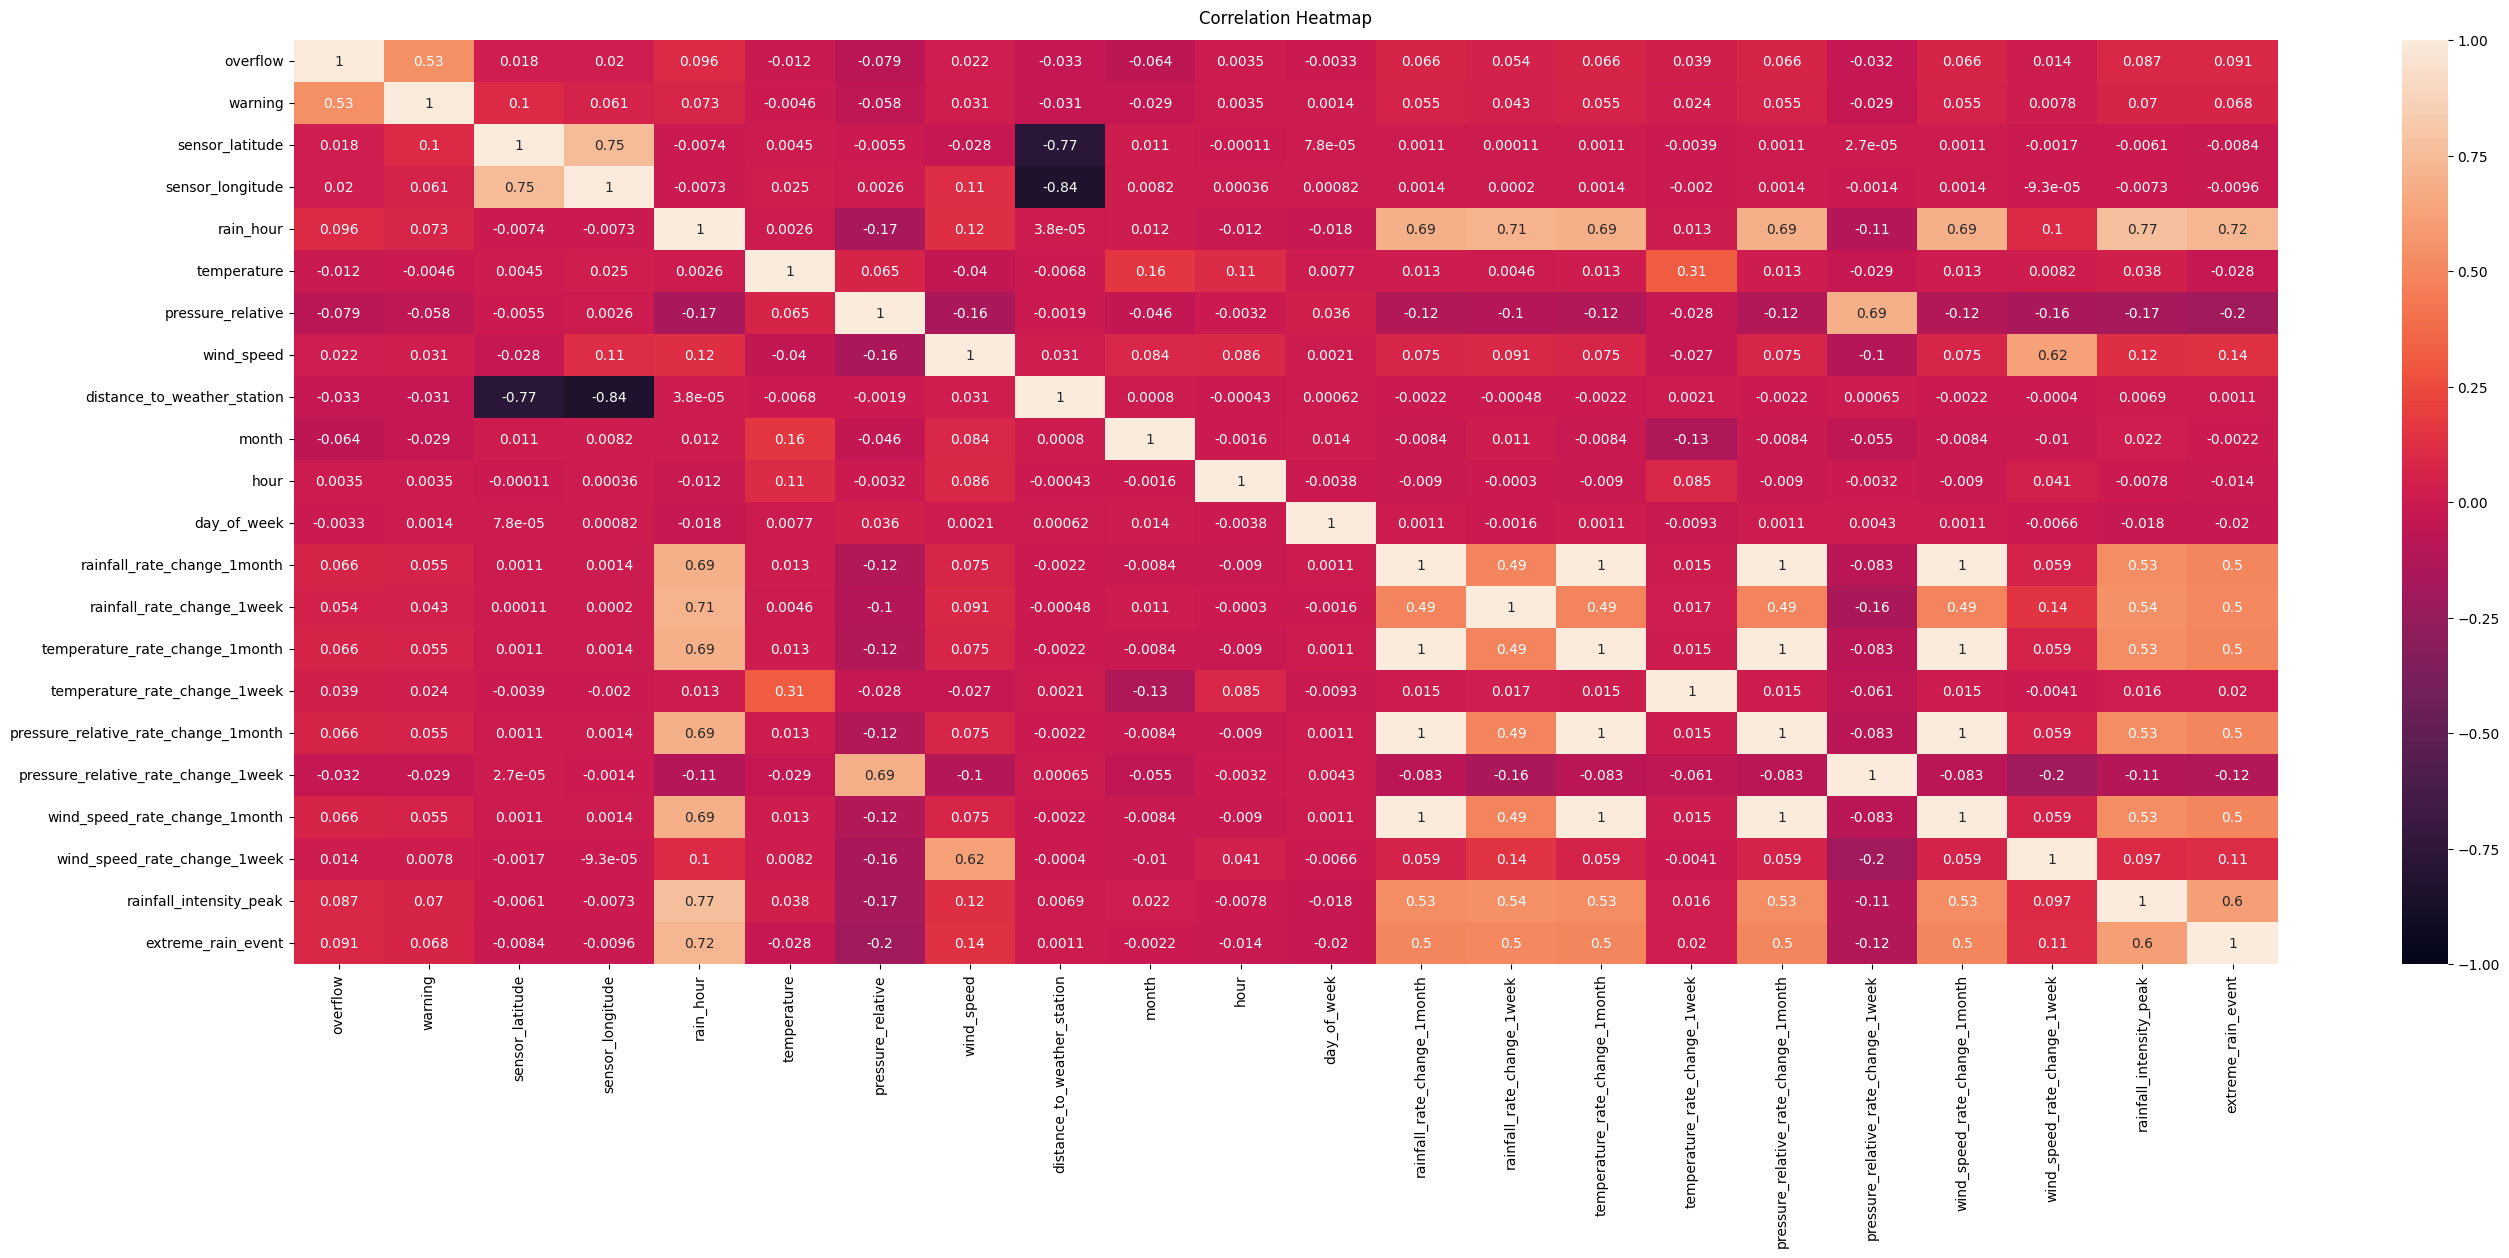

In [21]:
# Calculate the correlation matrix
corr = df.corr(numeric_only=True)

# Increase the size of the heatmap.
plt.figure(figsize=(32, 12))

# Plot the heatmap
heatmap = sb.heatmap(corr, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

### Select features

In [22]:
# Pick columns to keep based on correlation matrix
columns = ['overflow','rain_hour','rainfall_rate_change_1month', 'temperature_rate_change_1month', 'pressure_relative_rate_change_1month', 'wind_speed_rate_change_1month', 'extreme_rain_event', 'rainfall_intensity_peak', 'temperature']
df = df[columns]
df = df.fillna(0)

In [23]:
df.head()

,overflow,rain_hour,rainfall_rate_change_1month,temperature_rate_change_1month,pressure_relative_rate_change_1month,wind_speed_rate_change_1month,extreme_rain_event,rainfall_intensity_peak,temperature
time,,,,,,,,,
2020-11-11 17:00:00+01:00,0,0.951117,0.0,0.0,0.0,0.0,1,0.0,6.987134
2020-11-11 17:00:00+01:00,0,0.997241,0.0,0.0,0.0,0.0,1,0.0,6.993469
2020-11-11 18:00:00+01:00,0,0.683444,0.0,0.0,0.0,0.0,0,0.0,6.858736
2020-11-11 18:00:00+01:00,0,0.623115,0.0,0.0,0.0,0.0,0,0.0,6.950475
2020-11-11 19:00:00+01:00,0,0.278407,0.0,0.0,0.0,0.0,0,0.0,6.731556


## Visualize the data

### Plot timeseries

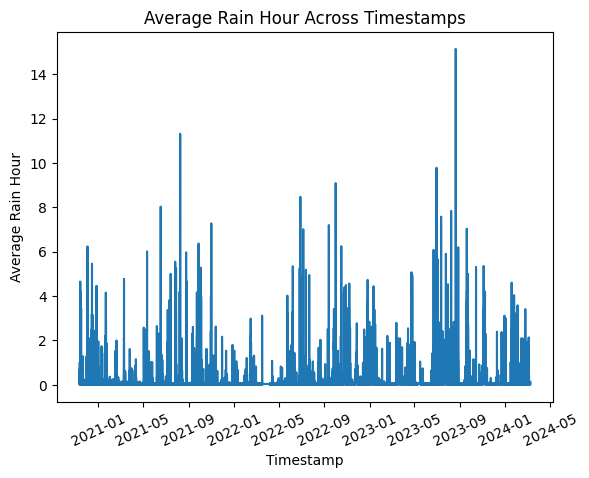

In [24]:
# Calculate the average rain_hour per timestamp
average_rain_hour = df.groupby('time')['rain_hour'].mean().reset_index()

# create the time series plot
sb.lineplot(x = "time", y = "rain_hour",
             data = average_rain_hour)

plt.xticks(rotation = 25)

# Customize the plot (add labels, title, etc.)
plt.xlabel('Timestamp')
plt.ylabel('Average Rain Hour')
plt.title('Average Rain Hour Across Timestamps')

# Show the plot
plt.show()

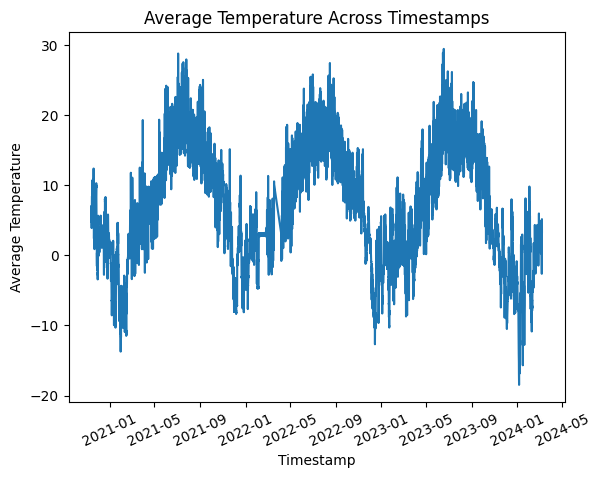

In [25]:
# Calculate the average temperature per timestamp
average_temperature = df.groupby('time')['temperature'].mean().reset_index()

# create the time series plot
sb.lineplot(x = "time", y = "temperature",
             data = average_temperature)

plt.xticks(rotation = 25)

# Customize the plot (add labels, title, etc.)
plt.xlabel('Timestamp')
plt.ylabel('Average Temperature')
plt.title('Average Temperature Across Timestamps')

# Show the plot
plt.show()

### Plot distribution of target variable

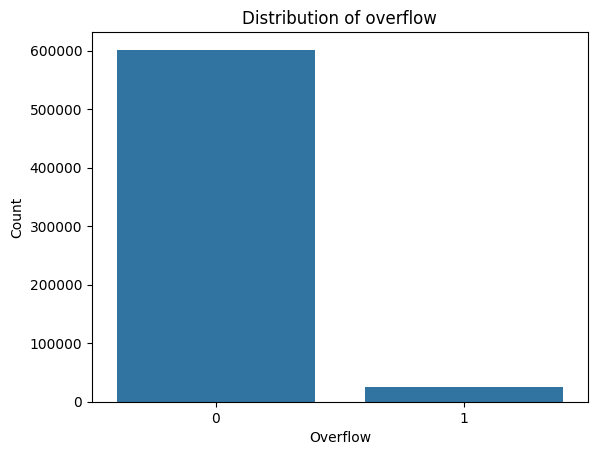

In [26]:
# Check the distribution of overflow (count of 0 and 1)
sb.countplot(data=df, x="overflow")

# Customize the plot (add labels, title, etc.)
plt.xlabel('Overflow')
plt.ylabel('Count')
plt.title('Distribution of overflow')

# Show the plot
plt.savefig("target_variable_distribution.svg", format='svg')
plt.show()

## Split into features and target variable

In [27]:
# Make copy of dataframe
ml_df = df.copy(deep=True)

# Split into test, training and validation
X = ml_df.drop(columns=['overflow'], axis='columns')
y = ml_df['overflow']

## Split data into train, test and validation sets

In [28]:
# Split into training, test and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=16)#, stratify=y_sm)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=16)#, stratify=y_train) # 0.25 x 0.8 = 0.2

## Scale the data

In [29]:
# Use SMOTE for sampling
resample = SMOTE(sampling_strategy='minority', k_neighbors=10)
print('Before SMOTE: ')
print(y_train.value_counts())
X_train, y_train = resample.fit_resample(X_train, y_train)
print('After SMOTE: ')
print(y_train.value_counts())

Before SMOTE: 
0    90193
1     3864
Name: overflow, dtype: int64
After SMOTE: 
0    90193
1    90193
Name: overflow, dtype: int64


## Normalize the data

In [30]:
# Perform normalization
norm = RobustScaler()
X_train = norm.fit_transform(X_train)
X_test = norm.fit_transform(X_test)
X_val = norm.fit_transform(X_val)

# Model development


## Logistic regression

In [30]:
# Build the model with defaults
ml_model_tuning = LogisticRegression()

### Hyperparameter tuning

In [99]:
# Use grid search to find the best parameters for LogisticRegression()
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV
C = [0.25, 0.5, 0.75, 1]
solver = ['saga'] #'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag',
max_iter = [100, 200, 300, 400]
parameters = {'solver':solver, 'C':C, 'max_iter':max_iter}
grid = GridSearchCV(ml_model_tuning, parameters, scoring=['f1','accuracy'], refit='f1')
grid_results = grid.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

In [105]:
# Summarize results
print("Best: %f using %s" % (grid_results.best_score_, grid_results.best_params_))
means = grid_results.cv_results_['mean_test_f1']
stds = grid_results.cv_results_['std_test_f1']
params = grid_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.358581 using {'C': 0.25, 'max_iter': 100, 'solver': 'saga'}
0.358581 (0.005778) with: {'C': 0.25, 'max_iter': 100, 'solver': 'saga'}
0.351033 (0.006794) with: {'C': 0.25, 'max_iter': 200, 'solver': 'saga'}
0.346047 (0.006705) with: {'C': 0.25, 'max_iter': 300, 'solver': 'saga'}
0.343865 (0.006632) with: {'C': 0.25, 'max_iter': 400, 'solver': 'saga'}
0.358568 (0.005790) with: {'C': 0.5, 'max_iter': 100, 'solver': 'saga'}
0.351067 (0.006776) with: {'C': 0.5, 'max_iter': 200, 'solver': 'saga'}
0.346044 (0.006726) with: {'C': 0.5, 'max_iter': 300, 'solver': 'saga'}
0.343823 (0.006630) with: {'C': 0.5, 'max_iter': 400, 'solver': 'saga'}
0.358563 (0.005792) with: {'C': 0.75, 'max_iter': 100, 'solver': 'saga'}
0.351044 (0.006788) with: {'C': 0.75, 'max_iter': 200, 'solver': 'saga'}
0.346027 (0.006736) with: {'C': 0.75, 'max_iter': 300, 'solver': 'saga'}
0.343818 (0.006630) with: {'C': 0.75, 'max_iter': 400, 'solver': 'saga'}
0.358563 (0.005792) with: {'C': 1, 'max_iter': 100, 'solver'

### Build and train the model

In [31]:
# Train the model
ml_model = LogisticRegression(max_iter=100, solver='saga', C=0.25, class_weight='balanced')
ml_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=0.25, class_weight='balanced', solver='saga')

### Predict

In [32]:
# Predict
y_pred_train = ml_model.predict(X_train)
y_pred_test = ml_model.predict(X_test)

### Evaluate

In [33]:
# Evaluation functions
def printClassificationReport(y_real, y_pred, set):
  # Print the classification report
  print(f'Classification repport for {set} set: ')
  print(metrics.classification_report(y_real, y_pred))
  print()

def printConfusionMatrix(y_real, y_pred):
  # Visualize confusion matrix
  plt.figure()
  classes = ['Not overflow', 'Overflow']
  cf_matrix = confusion_matrix(y_real, y_pred)
  cm = sb.heatmap(cf_matrix/np.sum(cf_matrix), fmt='.2%', annot=True, xticklabels=classes, yticklabels=classes)
  cm.set_xlabel('Predicted', fontsize=10)
  cm.set_ylabel('Actual', fontsize=10)
  cm.set_title('Confusion matrix')
  plt.savefig("confusion_matrix.svg", format='svg')
  plt.show()



Classification repport for test set: 
              precision    recall  f1-score   support

           0       0.97      0.86      0.91    481272
           1       0.08      0.28      0.12     20369

    accuracy                           0.83    501641
   macro avg       0.52      0.57      0.51    501641
weighted avg       0.93      0.83      0.88    501641




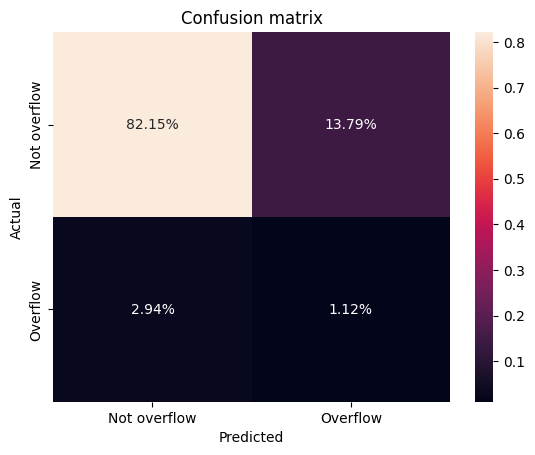

In [34]:
# Print classification report
printClassificationReport(y_test,y_pred_test, 'test')

# Print confusion matrix
printConfusionMatrix(y_test, y_pred_test)

## LSTM


In [35]:
# Reshape input data
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
X_val_reshaped = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

In [36]:
# Functions to define the model
def create_model(optimizer: str, activation: str):
  model = Sequential()
  model.add(Dropout(0.2, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
  model.add(LSTM(units=16, activation=activation, return_sequences=True))
  model.add(LSTM(units=8, activation=activation, return_sequences=True))
  model.add(LSTM(units=4, activation=activation))
  model.add(Dense(units=1, activation='sigmoid'))

  # Compile the model
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
  return model

### Hyperparameter tuning

In [ ]:
# Create KerasClassifier for our model using adam as optimizer
dl_model_classifier_adam = KerasClassifier(model=create_model('adam', 'tanh'), verbose=0)

In [ ]:
# Define the grid search parameters
batch_size = [10, 15, 25]
epochs = [1]
param_grid = dict(batch_size=batch_size, epochs=epochs)

# Perform the grid search
grid = GridSearchCV(estimator=dl_model_classifier_adam, param_grid=param_grid, n_jobs=-1, cv=3, error_score='raise')
grid_result = grid.fit(X_train_reshaped, y_train)

In [ ]:
# Summarize results from the grid search
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.621917 using {'batch_size': 25, 'epochs': 1}
0.614785 (0.001163) with: {'batch_size': 10, 'epochs': 1}
0.621513 (0.004167) with: {'batch_size': 15, 'epochs': 1}
0.621917 (0.001459) with: {'batch_size': 25, 'epochs': 1}


In [46]:
# Create the model
dl_model_adam = create_model('adam', 'tanh')
dl_model_sgd = create_model('SGD', 'tanh')

# Early stopping callback
# Will stop the training when there is no improvement in
# the validation loss for 10 consecutive epochs.
es = EarlyStopping(monitor='val_accuracy',
                                   mode='max', # don't minimize the accuracy!
                                   patience=10,
                                   restore_best_weights=True)

In [47]:
# Now we just update our model fit call
#history_adam = dl_model_adam.fit(X_train_reshaped,
#                    y_train,
#                    callbacks=[es],
#                    epochs=20,
#                    batch_size=25,
#                    validation_data=(X_val_reshaped,y_val),
#                    shuffle=True,
#                    verbose=2)

history_sgd = dl_model_sgd.fit(X_train_reshaped,
                    y_train,
                    callbacks=[es],
                    epochs=20,
                    batch_size=10,
                    validation_data=(X_val_reshaped,y_val),
                    shuffle=True,
                    verbose=2)

Epoch 1/20
18039/18039 - 113s - loss: 0.6900 - accuracy: 0.5343 - val_loss: 0.6715 - val_accuracy: 0.8061 - 113s/epoch - 6ms/step
Epoch 2/20
18039/18039 - 113s - loss: 0.6790 - accuracy: 0.5622 - val_loss: 0.6903 - val_accuracy: 0.8014 - 113s/epoch - 6ms/step
Epoch 3/20
18039/18039 - 113s - loss: 0.6747 - accuracy: 0.5675 - val_loss: 0.6884 - val_accuracy: 0.8095 - 113s/epoch - 6ms/step
Epoch 4/20
18039/18039 - 108s - loss: 0.6730 - accuracy: 0.5695 - val_loss: 0.6686 - val_accuracy: 0.8231 - 108s/epoch - 6ms/step
Epoch 5/20
18039/18039 - 110s - loss: 0.6697 - accuracy: 0.5729 - val_loss: 0.6845 - val_accuracy: 0.7703 - 110s/epoch - 6ms/step
Epoch 6/20
18039/18039 - 112s - loss: 0.6632 - accuracy: 0.5876 - val_loss: 0.6636 - val_accuracy: 0.7398 - 112s/epoch - 6ms/step
Epoch 7/20
18039/18039 - 109s - loss: 0.6598 - accuracy: 0.5974 - val_loss: 0.7064 - val_accuracy: 0.5853 - 109s/epoch - 6ms/step
Epoch 8/20
18039/18039 - 107s - loss: 0.6585 - accuracy: 0.5977 - val_loss: 0.7021 - val_a

### Build and train the model

### Predict

In [48]:
# Make predictions
predictions = dl_model_sgd.predict(X_test_reshaped)

15677/15677 [==============================] - 48s 3ms/step


Classification repport for test set: 
              precision    recall  f1-score   support

           0       0.97      0.85      0.90    481272
           1       0.08      0.31      0.13     20369

    accuracy                           0.83    501641
   macro avg       0.52      0.58      0.52    501641
weighted avg       0.93      0.83      0.87    501641




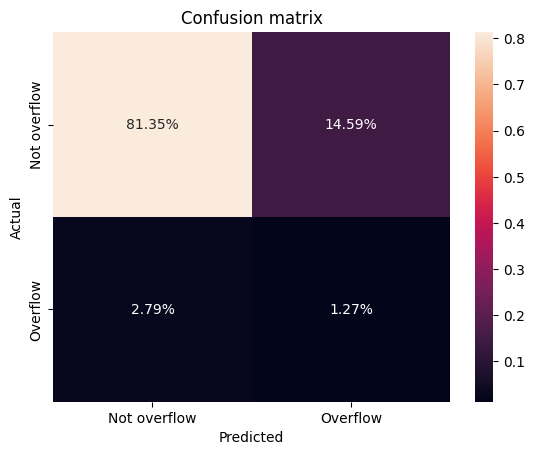

In [49]:
# Print classification report
printClassificationReport(y_test,predictions.round(), 'test')

# Print confusion matrix
printConfusionMatrix(y_test, predictions.round())

### Evaluate

In [ ]:
# Evaluate the model on the test data using `evaluate`
score = dl_model_adam.evaluate(X_test_reshaped, y_test, verbose=0)
print(f'Loss: {score[0]}  Accuracy: {score[1]}') #dl_model_adam.metrics_names gives the labels

Loss: 0.6653043031692505  Accuracy: 0.6293863654136658


### Visualising the training loss and accuracies


In [ ]:
# Functions to plot model loss and accuracy
def plot_model_loss(history):
  plt.figure(figsize=(10,4))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend(['Train','Val'], loc= 'upper left')
  plt.show()

def plot_model_accuracy(history):
  plt.figure(figsize=(10,3))
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

In [ ]:
# TODO: Create a function for all evaluation stuff

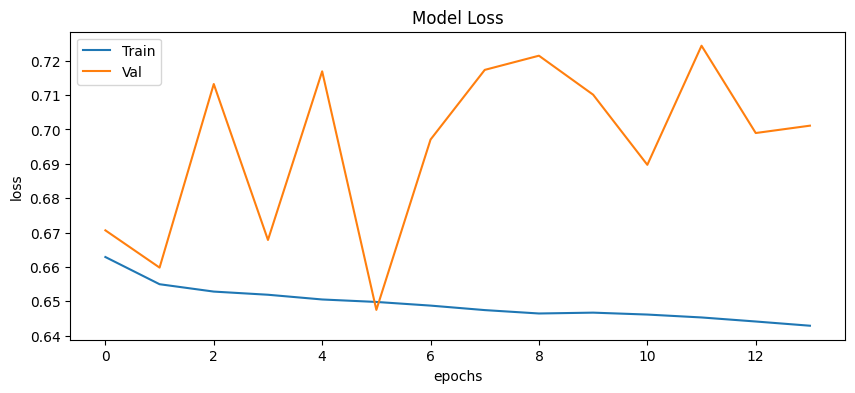

In [ ]:
plot_model_loss(history_sgd)

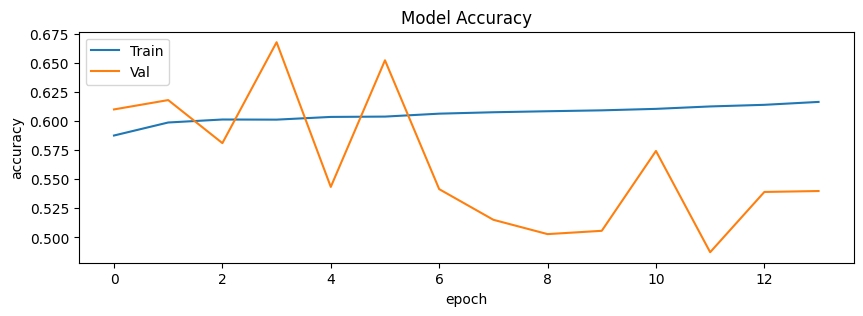

In [ ]:
plot_model_accuracy(history_sgd)

In [ ]:
# Get the predicted class for each measurement
#predicted_classes = np.argmax(predictions, axis=1)

#print('Predicted classes:', predicted_classes)
#print('True labels:', y_test)

In [ ]:
#from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
#print('Accuracy:\n', accuracy_score(y_test, predicted_classes))

In [ ]:
#print('Classification Report:\n', classification_report(y_test, predicted_classes))